In [23]:
# Required imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, f1_score

In [24]:
# Load the data
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                   'arrhythmia/arrhythmia.data', header=None, sep=',', engine='python')

display(data.head(3))

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10


In [25]:
# Change dataset label
data['arrhythmia'] = data[len(data.columns)-1].map(lambda x: 0 if x==1 else 1)
data = data.drop(len(data.columns)-2, axis=1)

In [26]:
# Only use columns which has numeric data
data = data._get_numeric_data()
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,arrhythmia
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,1
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,1
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,1


In [27]:
# Extract our features + label
X = data.iloc[:, :-1]  # The first to second-last columns are the features
y = data.iloc[:, -1]   # The last column is the ground-truth label

In [28]:
# splitting the dataset to training and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20181004)

In [29]:
# Standardizing the training and test datasets
# Note that we are scaling based on the information from the training data
# Then we apply the scaling that is done from training data to the test data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [30]:
# Logistic regression model
class LogisticRegression(object):

    def __init__(self, eta=0.05, n_epoch=100, random_state=1):
        self.eta = eta
        self.n_epoch = n_epoch
        self.random_state = random_state
    
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_epoch):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = self.loss(output, y)
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def loss(self, output, y):
        """Calculate loss"""
        return -1 * ((y.T.dot(np.log(output))) + ((1 - y).T.dot(np.log(1 - output)))) / len(y)
    
    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1 / (1 + np.exp(-z))

    def predict(self, X):
        """Return class label after unit step"""
        z = np.dot(np.c_[np.ones((np.shape(X)[0], 1)), X], self.w_)
        y_pred = []

        for i in self.activation(z):
            if i>0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)
                
        return np.array(y_pred)

In [71]:
# Initialize model + fit
model = LogisticRegression(0.001, 500, 12)
model.fit(X_train_std, y_train)

In [72]:
# Predict Y
y_pred = model.predict(X_test_std)
y_pred_train = model.predict(X_train_std)

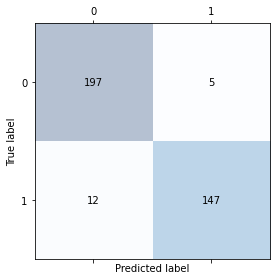

In [73]:
# Draw the confusion matrix (Training)
confmat = confusion_matrix(y_true = y_train, y_pred = y_pred_train)

fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()

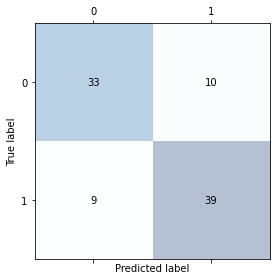

In [74]:
# Draw the confusion matrix (Testing)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)

fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()

In [75]:
# Calculate F1 Score
print('[F1-score Training]')
f = f1_score(y_true=y_train, y_pred=y_pred_train, average=None)
print('Individual: %.2f, %.2f' % (f[0], f[1]))
f = f1_score(y_true=y_train, y_pred=y_pred_train, average='micro')
print('Micro: %.2f' % f)
f = f1_score(y_true=y_train, y_pred=y_pred_train, average='macro')
print('Macro: %.2f' % f)

print('\n[F1-score Testing]')
f = f1_score(y_true=y_test, y_pred=y_pred, average=None)
print('Individual: %.2f, %.2f' % (f[0], f[1]))
f = f1_score(y_true=y_test, y_pred=y_pred, average='micro')
print('Micro: %.2f' % f)
f = f1_score(y_true=y_test, y_pred=y_pred, average='macro')
print('Macro: %.2f' % f)

[F1-score Training]
Individual: 0.96, 0.95
Micro: 0.95
Macro: 0.95

[F1-score Testing]
Individual: 0.78, 0.80
Micro: 0.79
Macro: 0.79
